# Differentailly Private Deep Learning accounted by Gaussian differential privacy (Noise) + Define Guaranteed Privacy Level (Delta) to create lower Lower Privacy Cost (Epsilon)

### This is a tutorial of how to train deep neural networks with differential privacy, a mathematically rigorous privacy definition that defends against privacy leakage, e.g. the [membership inference attack](https://github.com/tensorflow/privacy/tree/master/tensorflow_privacy/privacy/membership_inference_attack).

### Our tutorial is based on the Pytorch library, [**Opacus**](https://github.com/pytorch/opacus). First we install Opacus.

Ref: https://github.com/pytorch/opacus

In [12]:
# !pip install opacus # latest version==1.5.2
!pip install opacus==0.13.0

### We also need the privacy accountants including our GDP accountant

In [13]:
!git clone https://github.com/woodyx218/Deep-Learning-with-GDP-Pytorch.git

Cloning into 'Deep-Learning-with-GDP-Pytorch'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 54 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 420.89 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [14]:
cd /content/Deep-Learning-with-GDP-Pytorch

/content/Deep-Learning-with-GDP-Pytorch


### Import necessary packages.

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from opacus import PrivacyEngine
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.utils.data import DataLoader

### We use MNIST here, similar to
https://github.com/pytorch/opacus/blob/master/examples/mnist.py

In [16]:
batch_size=256
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data",train=True,download=True,
                   transform=transforms.Compose(
                       [transforms.ToTensor(),
                        transforms.Normalize((0.1307), (0.3081)),])
                   ), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data",train=False,
                   transform=transforms.Compose(
                       [transforms.ToTensor(),
                        transforms.Normalize((0.1307), (0.3081)),])
                   ), batch_size=batch_size, shuffle=False)


### We define a simple CNN, almost same as [Tensorflow Privacy example](https://github.com/tensorflow/privacy/blob/master/tutorials/Classification_Privacy.ipynb) and [Opacus example](https://github.com/pytorch/opacus/blob/master/examples/mnist.py), but we use **tanh** activation instead of **relu** for better performance (see https://arxiv.org/abs/2007.14191).

In [17]:
class SampleConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        # x of shape [B, 1, 28, 28]
        x = F.tanh(self.conv1(x))  # -> [B, 16, 14, 14]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 13, 13]
        x = F.tanh(self.conv2(x))  # -> [B, 32, 5, 5]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 4, 4]
        x = x.view(-1, 32 * 4 * 4)  # -> [B, 512]
        x = F.tanh(self.fc1(x))  # -> [B, 32]
        x = self.fc2(x)  # -> [B, 10]
        return x

    def name(self):
        return "SampleConvNet"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cnn_DP=SampleConvNet().to(device)

### Now that we have the data preprocessed and the model defined, we move on to set the training process for the optimizer. We define a class to include the hyperparameters.

In [18]:
# @title Hyper-parameters from argument
class Args:
    epochs=5 # number of epochs
    n_runs=1 # allow multiple independent run so you can take average of accuracy
    lr=0.25 # learning rate
    sigma=5.0 #  [0.0, 0.75, 1.3, 2.5, 5.0] noise multiplier in the DP optimizer, necessary to set to non-zero for DP; 1.3
    max_per_sample_grad_norm=1.5  # clipping norm to guarantee the sensitivity of gradients; necessary to set to non-infinity for DP
    delta=1e-10 # [1e-10, 1e-8, 1e-5, 1e-2, 1e-0] delta (guaranteed privacy level of delta lead to privacy budget of Epsilon) in (epsilon, delta)-DP, need to be smaller than 1/sample size; 1.5

    disable_dp=False
    # if True, then this is training with no clipping (hence not DP);
    # if False, and if sigma not zero, then DP; else, this is non-DP training with clipping

args = Args()

### Next, we define the training function and attach any regular optimizer (SGD, Adagrad, Adam) to the **privacy engine** (which automatically turns optimizer into DP-optimizer, and calculates your privacy risk on the fly).

In [19]:
def epoch(loader, model, opt=None):
    total_loss, total_err = 0.,0.
    if opt:
      model.train()
    else:
      model.eval()
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

opt_DP = optim.SGD(cnn_DP.parameters(), lr=args.lr)

# only this privacy engine is from Opacus
privacy_engine = PrivacyEngine(
    cnn_DP,
    batch_size=batch_size,
    sample_size=len(train_loader.dataset),
    alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
    noise_multiplier=args.sigma,
    max_grad_norm=args.max_per_sample_grad_norm,
    target_delta=args.delta
)
privacy_engine.attach(opt_DP)

print(' '*20,'Train Accuracy , Train Cross-Entropy Loss, Test Accuracy , Test Cross-Entropy Loss, ')
for Epoch in range(args.epochs):
    train_err_DP, train_loss_DP = epoch(train_loader, cnn_DP, opt_DP)
    test_err_DP, test_loss_DP = epoch(test_loader, cnn_DP)
    print('Epoch',Epoch+1,'--> DP:',' '*5,*("{:.6f}".format(i) for i in (1-train_err_DP, train_loss_DP, 1-test_err_DP, test_loss_DP)), sep="\t")
    epsilon, best_alpha = privacy_engine.get_privacy_spent()
    print(f" | (ε = {epsilon:.2f}, δ = {privacy_engine.target_delta}) for α = {best_alpha}")

/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:517: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/opacus/privacy_engine.py:194: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


                     Train Accuracy , Train Cross-Entropy Loss, Test Accuracy , Test Cross-Entropy Loss, 
Epoch	1	--> DP:	     	0.675733	1.106429	0.808200	0.635100
 | (ε = 0.38, δ = 1e-10) for α = 63.0
Epoch	2	--> DP:	     	0.822850	0.566255	0.838400	0.522644
 | (ε = 0.38, δ = 1e-10) for α = 63.0
Epoch	3	--> DP:	     	0.831217	0.543112	0.832500	0.538357
 | (ε = 0.39, δ = 1e-10) for α = 63.0
Epoch	4	--> DP:	     	0.828700	0.555960	0.842900	0.518421
 | (ε = 0.39, δ = 1e-10) for α = 63.0
Epoch	5	--> DP:	     	0.830800	0.574090	0.843000	0.533381
 | (ε = 0.40, δ = 1e-10) for α = 63.0


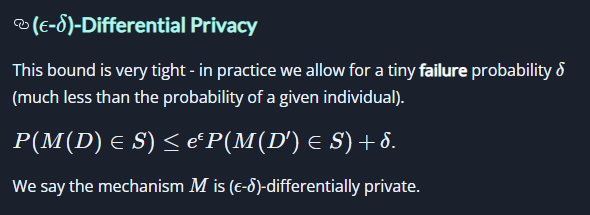

Ref: https://mukulrathi.com/privacy-preserving-machine-learning/deep-learning-differential-privacy/ \
Ref2: https://opacus.ai/docs/faq

In the context of differential privacy, especially in machine learning, the terms
ϵ (epsilon),
δ (delta), and
σ (sigma) are parameters that describe the privacy guarantees of an algorithm.\
ในบริบทของการคุ้มครองความเป็นส่วนตัวแบบต่างๆ (differential privacy) โดยเฉพาะในการเรียนรู้ของเครื่อง (machine learning) คำว่า
ϵ (epsilon), δ (delta) และ σ (sigma) เป็นพารามิเตอร์ที่ใช้บรรยายการรับประกันความเป็นส่วนตัวของอัลกอริธึม

\
(ϵ-δ)-Differential Privacy
This bound is very tight - in practice we allow for a tiny failure probability
δ (much less than the probability of a given individual).

P(M(D)∈S) ≤ e^[ϵ] x P(M(D′)∈S) + [δ].\
We say the mechanism
M is (ϵ,δ)-differentially private.


-----
δ (Delta):

Definition: Delta is a parameter used in
(ϵ,δ)-differential privacy to account for a small probability that the privacy guarantees do not hold. It represents the probability with which the privacy guarantee might be violated. Essentially, it allows for a small chance that the privacy loss can be more significant than
ϵ suggests.\
คำจำกัดความ:
δ เป็นพารามิเตอร์ที่ใช้ใน
(ϵ,δ)-differential privacy เพื่อรองรับความเป็นไปได้เล็กน้อยที่การรับประกันความเป็นส่วนตัวอาจไม่เป็นไปตามที่คาดการณ์ไว้ แสดงถึงความน่าจะเป็นที่การรับประกันความเป็นส่วนตัวอาจถูกละเมิด

\
Given Value: δ=1×10^−6
 . This very small value indicates that the chance of the privacy guarantee failing is extremely low.\
ค่าในที่นี้:
δ=1×10^−6
  ค่าเล็กมากนี้หมายความว่าความน่าจะเป็นที่การรับประกันความเป็นส่วนตัวจะผิดพลาดนั้นต่ำมาก กล่าวคือ ยิ่งต่ำมาก การรับประกันนั้นสูง ผิดพลาดน้อยถึงน้อยมาก

-----
σ (Sigma):

Definition: Sigma typically refers to the standard deviation of the noise added to the data or the mechanism used to achieve differential privacy. For algorithms like the *Laplace Noise* mechanisms on normal Gaussian σ, sigma represents how much noise is added to the data to ensure privacy. Larger values of sigma correspond to more noise, which increases privacy but also reduces the utility of the data.\
คำจำกัดความ: σ โดยปกติหมายถึงส่วนเบี่ยงเบนมาตรฐานของสัญญาณรบกวนที่เพิ่มเข้าไปในข้อมูลหรือกลไกที่ใช้ในการบรรลุความเป็นส่วนตัวแบบต่างๆ สำหรับอัลกอริธึมเช่น กลไก *Laplace Noise* บน Normal Gaussian σ แสดงถึงปริมาณของสัญญาณรบกวนที่เพิ่มเข้าไปในข้อมูลเพื่อให้แน่ใจว่ามีความเป็นส่วนตัว ค่าของ σ ที่ใหญ่กว่าจะหมายถึงสัญญาณรบกวนมากขึ้น ซึ่งเพิ่มการปกป้องความเป็นส่วนตัวแต่ลดประสิทธิภาพของข้อมูลลง

\
Context: For a Gaussian mechanism to provide (ϵ,δ)-differential privacy (DP), the standard deviation
σ of the Gaussian noise is related to
ϵ and δ through specific formulas. The relationship depends on the desired privacy parameters and the sensitivity of the function being privatized.\
บริบท: สำหรับกลไก Gaussian ที่ใช้กับ (ϵ,δ)-DP ค่าของส่วนเบี่ยงเบนมาตรฐาน
σ จะเชื่อมโยงกับ ϵ และ δ ผ่านสูตรเฉพาะ ความสัมพันธ์นี้ขึ้นอยู่กับพารามิเตอร์ความเป็นส่วนตัวที่ต้องการและความไวของฟังก์ชันที่ได้รับการปกป้อง

-----

ϵ (Epsilon):

Definition: Epsilon measures the privacy loss (privacy cost/budget). A smaller
ϵ indicates stronger privacy protection. It quantifies how much the output of the algorithm can change when a single individual's data is added or removed. In formal terms, it is the parameter in the differential privacy definition that bounds the probability ratio of any two outcomes (with and without a single individual's data).\
วัดการสูญเสียความเป็นส่วนตัว (ต้นทุนความสูญเสีย) ซึ่งค่า
ϵ ที่น้อยกว่าหมายถึงการปกป้องความเป็นส่วนตัวที่แข็งแกร่งกว่า มันจะบอกว่าผลลัพธ์ของอัลกอริธึมสามารถเปลี่ยนแปลงได้มากน้อยเพียงใดเมื่อข้อมูลของบุคคลหนึ่งถูกเพิ่มเข้าหรือเอาออก การกำหนดค่าทางการคำนวณในความเป็นส่วนตัวแบบต่างๆ วัดอัตราส่วนความน่าจะเป็นของผลลัพธ์ที่แตกต่างกัน

\
Given Value: ϵ=0.85. This means the algorithm has a privacy loss of 0.85, which is considered quite low and implies a reasonable level of privacy protection.\
ค่าในที่นี้: ϵ=0.85 ซึ่งหมายถึงการสูญเสียความเป็นส่วนตัวที่ 0.85 ถือว่าค่อนข้างต่ำ (มีความเป็นส่วนตัวของข้อมูลสูง) และบ่งบอกถึงการปกป้องความเป็นส่วนตัวในระดับที่เหมาะสม

-----

α (alpha): \
Although we report expended privacy budget using the (epsilon, delta) language, internally, we track it using Rényi Differential Privacy (RDP) [Mironov 2017, Mironov et al. 2019]. In short, (alpha, epsilon)-RDP bounds the Rényi divergence of order alpha between the distribution of the mechanism’s outputs on any two datasets that differ in a single element.\
(alpha, epsilon)-RDP เป็นการกำหนดขอบเขตของ Rényi divergence ที่มีลำดับ alpha ระหว่างการกระจายของผลลัพธ์ของกลไกบนสองชุดข้อมูลใดๆ ที่ต่างกันเพียงองค์ประกอบเดียว (alpha, epsilon)-RDP เป็นการผ่อนคลายของ epsilon-DP แต่ยังคงรักษาคุณสมบัติสำคัญหลายประการที่ทำให้ RDP เหมาะอย่างยิ่งสำหรับการวิเคราะห์ความเป็นส่วนตัวของ DP-SGD พารามิเตอร์ alphas แจ้งให้เครื่องมือความเป็นส่วนตัวทราบว่าจะใช้ลำดับ RDP ใดในการติดตามการใช้จ่ายความเป็นส่วนตัว

\
When the privacy engine needs to bound the privacy loss of a training run using (epsilon, delta)-DP for a given delta, it searches for the optimal order from among alphas. There’s very little additional cost in expanding the list of orders. We suggest using a list [1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)). You can pass your own alphas by passing alphas=custom_alphas when calling privacy_engine.make_private_with_epsilon.\
เมื่อเครื่องมือความเป็นส่วนตัวต้องการกำหนดขอบเขตการสูญเสียความเป็นส่วนตัวของการฝึกโดยใช้ (epsilon, delta)-DP สำหรับ delta ที่กำหนด จะค้นหาลำดับที่เหมาะสมจาก alphas การขยายรายการลำดับนั้นมีต้นทุนเพิ่มเติมเพียงเล็กน้อย เราแนะนำให้ใช้รายการ [1 + x / 10.0 สำหรับ x ในช่วง (1, 100)] + รายการ (ช่วง 12 ถึง 64) หรือสามารถกำหนด alphas ด้วยตัวเองได้โดยส่ง alphas=custom_alphas เมื่อเรียก privacy_engine.make_private_with_epsilon

-----

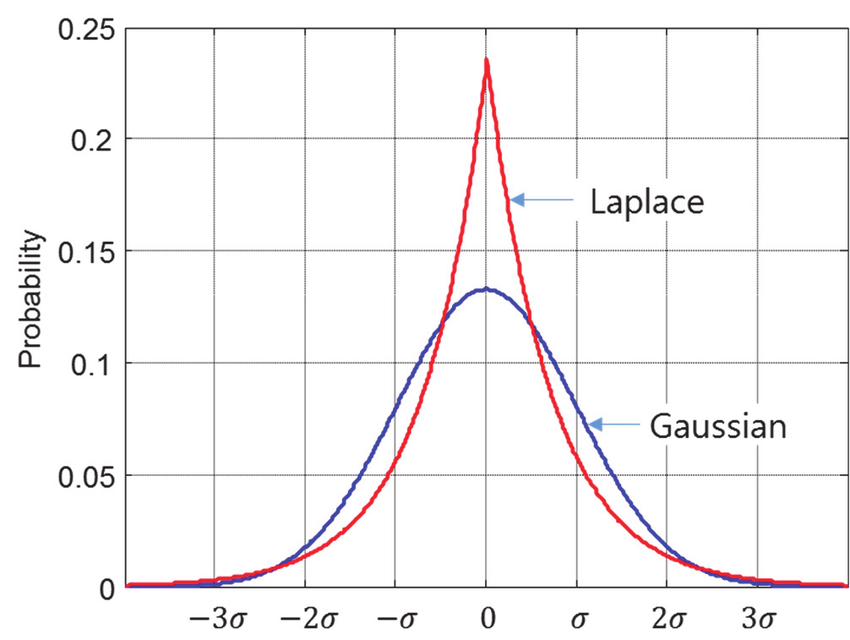


"Moment Accountant" และ "Gaussian Differential Privacy" เป็นสองแนวคิดที่เกี่ยวข้องกับความเป็นส่วนตัวในข้อมูลและการวิเคราะห์เชิงสถิติ:

Moment Accountant (MA):

MA เป็นเทคนิคที่ใช้ในการวัดและควบคุมความเป็นส่วนตัวของข้อมูลในระบบที่ใช้ Differential Privacy (DP) ซึ่งเป็นแนวทางในการปกป้องข้อมูลส่วนบุคคล
วิธีการนี้มักถูกนำมาใช้เพื่อคำนวณและควบคุมการละเมิดความเป็นส่วนตัวโดยการวัด "moments" หรือ "ช่วง" ของการแจกแจงของข้อมูลที่อาจรั่วไหลออกมาในระบบ
Moment Accountant ช่วยให้เราสามารถประเมินและควบคุมความเป็นส่วนตัวได้ในเชิงพรรณนา โดยการติดตามการเปลี่ยนแปลงของข้อมูลในช่วงเวลาต่างๆ

Gaussian Differential Privacy (GDP):

GDP เป็นการปรับใช้ Differential Privacy โดยใช้การกระจายแบบ Gaussian (หรือ Normal distribution) เพื่อสร้าง "noise" หรือสัญญาณรบกวนที่ทำให้ข้อมูลที่เราต้องการปกปิดมีความเป็นส่วนตัวมากขึ้น
ใน GDP, การเพิ่ม noise แบบ Gaussian เข้าไปในข้อมูลช่วยให้ข้อมูลมีความเป็นส่วนตัวมากขึ้น โดยที่ผู้โจมตีไม่สามารถดึงข้อมูลส่วนบุคคลออกมาได้ง่าย
การใช้ Gaussian noise ช่วยให้การควบคุมความเป็นส่วนตัวและการคำนวณเป็นไปได้ง่ายและมีประสิทธิภาพ โดยการกำหนดพารามิเตอร์อย่างเช่น "variance" ของ Gaussian noise จะส่งผลต่อระดับความเป็นส่วนตัวที่สามารถบรรลุได้
ทั้งสองแนวคิดนี้เป็นส่วนสำคัญของการออกแบบระบบที่ต้องการให้ความเป็นส่วนตัวของข้อมูลสูงสุด ในการวิเคราะห์ข้อมูลหรือระบบที่ต้องการการปกป้องข้อมูลที่เข้มงวด

#### There exist many privacy accountants that give you an upper bound on epsilon. The most popular ones are [Moments Accountant](https://arxiv.org/abs/1607.00133) (MA) and Gaussian DP (GDP; promoted by this paper).

There are many variants of MA. E.g. in the above, Opacus uses a version of MA that gives epsilon = 1.32. In below, Tensorflow Privacy uses another MA that gives epsilon = 0.94 and Opacus's GDP accountant gives epsilon = 0.82. Hence GDP is the tightest privacy guarantee.

\
มีหลายรูปแบบของ MA (Mechanism for Differential Privacy) ตัวอย่างเช่นในตัวอย่างข้างต้น Opacus ใช้เวอร์ชันหนึ่งของ MA ที่ให้ค่า ϵ=1.32 ในขณะที่ Tensorflow Privacy ใช้ MA อีกแบบหนึ่งที่ให้ค่า ϵ=0.94 และ GDP accountant ของ Opacus มีค่า ϵ=0.82-0.85 ดังนั้น GDP จึงให้การรับประกันความเป็นส่วนตัวที่แน่นหนาที่สุด

In [20]:
# !pip uninstall -y tensorflow-probability
# !pip install tensorflow-probability==0.18.0
# !pip install tensorflow-privacy==0.7.3
# !pip install tensorflow-estimator==2.9.0 # Install a compatible tensorflow-estimator version
# !pip install tensorflow==2.9.0  # Install a compatible tensorflow version
# import tensorflow_privacy
from gdp_accountant import compute_epsP, compute_epsilon # which uses tensorflow-privacy package
print('eps_MA (Moments Accountant - TensorFlow Epsilon) = %.6g' %(compute_epsilon(15,1.3,60000,256,1e-5))) # [epoches, sigma, batch_size, delta]
print('eps_GDP (Gaussian Differential Privacy - Opacus Epsilon) = %.6g' %(compute_epsP(15,1.3,60000,256,1e-5)))  # [epoches, sigma, batch_size, delta]

eps_MA (Moments Accountant - TensorFlow Epsilon) = 0.954514
eps_GDP (Gaussian Differential Privacy - Opacus Epsilon) = 0.834463


In [21]:
# # @title For Opacus version >==1.0 to make privacy to model, optimizer, loader
# """
#   Note: For Opacus version >==1.0
# """
# !pip install opacus==1.5.2

# # enter PrivacyEngine
# privacy_engine = PrivacyEngine()
# model, optimizer, data_loader = privacy_engine.make_private(
#     module=SampleConvNet,
#     optimizer=opt_DP,
#     data_loader=train_loader,
#     noise_multiplier=1.3,
#     max_grad_norm=1.5,
# )

-------
# Homework
**Note: ใช้ Opacus version == 0.13.0**\
ปรับ argument ทั้งหมดตามตัวอย่างข้างใต้
- Epoch: 5
- Sigma; σ (Laplace noise multiplier;ตัวคูณเพิ่ม noise ให้กับการความน่าจะเป็นของข้อมูล)
- Delta; δ (Guaranteed privacy level; ระดับความเป็นส่วนตัวที่ทำให้ต้นทุน ϵ ไม่ล้มเหลว [ไม่มากจนเกินไป] ในระหว่างการปกปิดกับข้อมูลที่เรียนรู้)

\
ที่ทำให้ต้นทุนมีต้นทุนความเป็นส่วนตัว ϵ น้อยสุดและยังรักษาการทดสอบประสิทธิภาพโมเดลช่วงอนุมานได้ดีอยู่ (เท่าที่ทำได้) จากการปรับ [Sigma, Delta] ข้างใต้รายละเอียด\
Note: Epsilon; ϵ (Privacy loss; ต้นทุนความเป็นส่วนตัว)



```
# @title Hyper-parameters for homework argument
class Args:
    epochs=5
    n_runs=1
    lr=0.25

    max_per_sample_grad_norm=1.5  
    # clipping norm to guarantee the sensitivity of gradients; necessary to set to non-infinity for DP
    
    #VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
    sigma= low added noise<-- [0.0, 0.75, 1.3, 2.5, 5.0] -->high added noise
    # noise multiplier in the DP optimizer, necessary to set to non-zero for DP

    delta= less privacy failure<-- [1e-10, 1e-8, 1e-5, 1e-2, 1e-0] -->more privacy failure
    # delta (lead to privacy budget of Epsilon) in (epsilon, delta)-DP, need to be smaller than 1/sample size
    #AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

    disable_dp=False

args = Args()


```




เปรียบเทียบ 3 กรณี ในกรณีเดียวกัน ถ้า
- 1.) ปรับเพียง privacy level (delta); noise = 0
```
# คู่การปรับ Noise (Sigma) + Guaranteed Privacy Level (Delta)
[sigma, delta] = {
  Just add privacy level: [0.0, 1e-10], [0.0, 1e-8], [0.0, 1e-5], [0.0, 1e-2]
  }
```
- 2.) ปรับเพียง noise (sigma); privacy level = 1
```
# คู่การปรับ Noise (Sigma) + Guaranteed Privacy Level (Delta)
[sigma, delta] = {
  Just add noise: [0.75, 1], [1.3, 1], [2.5, 1], [5.0, 1]
  }
```
- 3.) ปรับทั้ง privacy level (delta) & noise
```
# คู่การปรับ Noise (Sigma) + Guaranteed Privacy Level (Delta)
  Add both noise and privacy level: [0.0, 1e-0], [0.75, 1e-2], [1.3, 1e-5], [2.5, 1e-8], [5.0, 1e-10]
  }
```

\
จากการปรับ Sigma-Delta ในทุก ๆ ค่าที่ให้ไว้ใน array ตัวอย่างข้างบน สังเกค \
- ต้นทุนความสูญเสียความเป็นส่วนตัว (Privacy Cost/Budget; ϵ)
- Train-Test Accuracy & loss ในขณะที่ทำ DP ระหว่างฝึกฝนและอนุมาน\

เปรียบเทียบและอภิปรายผลการเพิ่มความเป็นส่วนตัวของข้อมูลด้วยวิธีการแบบ ((ϵ,δ)-differential privacy) จัดทำเป็น PDF



------

## Some Tips:

1. Larger epsilon and delta means model is *less private*
2. Fixing other hyperparameters, more iterations/epochs *less private*
3. Learning rate and clipping norm do not affect DP but affect convergence
4. Iteration, sigma, batch size and sample size affect DP
5. One set of training corresponds to infinitely many (epsilon,delta) pairs, usually we choose delta = 1/sample size
6. Practionally, one tunes clipping norm first with sigma = 0, then fix clipping norm and tune sigma, under pre-specified privacy budget (e.g. epsilon < 8)
